# Exploratory Data Analysis for Final Project

In this assignment, your task is to put your new skils to use in the form of an open-ended, exploratory data analysis. In particular, I'm looking for you to demonstrate your ability to use the programmatic tools we've been learning to access data, manipulate it, and visualize some findings while working towards the ultimate goal of developing a final project proposal. Please include the following in your assignment:

  1. A brief summary of the topic (a few sentences)
  2. Access 2 or more datasets, at least one of them using an API (if you are not using any data from an API as part of your project yet, don’t worry about it, and just do this to get some exercise using APIs. You might use it later).
  3. Demonstrate the use of Pandas operations to filter out missing data and/or outliers.
  4. Demonstrate your capacity to use some of the "group-by" operations to produce pivot tables or statistical summaries of your data.
  5. Use Matplotlib or Seaborn to produce 2-3 data visualizations of your data to both explore the data and highlight any notable patterns.
  6. Include a short written analysis of your interpretation of the data.
  7. In a few paragraphs, describe the research question you intend to investigate in your final project, and the plan for the data analysis you intend to perform.

Note that this exercise is intended to help you formulate your project topic. But it is not a binding contract. Your project will most likely evolve over the rest of the semester. So use this as an opportunity to be creative, throw some ideas against the wall and see what sticks. I will release the final project guidelines shortly. In the meantime, dig in!

And as always, please submit this assignment both as a PR on GitHub along with the URL of your PR on bCourses.

# Topic & Datasets

My Master's thesis is looking at the distributional impact of flood risk, gaps in physical protection financing for risk reduction. I am including a case study in San Mateo County that looks at the following data sources:

1. **Parcel Data:** desired attributes = assessed value, lot size, building area. <br>*Source:* ParcelAtlas, 2021 data, proprietary but made available through UC Berkeley GIS Librarian. <br>*Format:* shapefile.


2. **Annual Avoided Losses (AAL):** Expected annual structure and contents damage from coastal flooding, aggregated over and averaged across 2020–2060, utilizing the values for RCP Scenario 8.5. <br>*Source:* Bick et al. (2021). Rising seas, rising inequity? Communities at risk in the San Francisco Bay Area and implications for adaptation policy. Earth's Future, 9, e2020EF001963 [link.](https://doi-org.libproxy.berkeley.edu/10.1029/2020EF001963) <br>*Format:* CSV, needs to be joined to building footprint data to be spatialized and merged with parcel dataset. 


3. **Community Vulnerability Data:** The San Francisco Bay Conservation and Development Commission Adapting to Rising Tides Program developed a dataset to better understand community vulnerability to current and future flooding due to sea level rise and storm surges. Data is sources from ACS and CalEnviroScreen and is at the census block group level. <br>*Source:* 2023 Community Vulnerability Data from San Francisco Bay Conservation & Development Commission (BCDC). <br>*Format:* shapefile. 


4. **ABAG Flood Protection Project Costs Data:** Sea Level Rise Adaptation Funding and Investment Framework Shoreline Project Inventory, published in 2023. <br>*Source:* Association of Bay Area Government (ABAG). <br>*Format:* Project Costs by County, including San Mateo County, as a xlsx workbook [here]('https://mtc.ca.gov/digital-library/5024319-sea-level-rise-adaptation-funding-and-investment-framework-shoreline-project-inventory'). Project Inventory and Placeholders shapefile sent directly by email from  ABAG staff. 

My research analysis design utilzing these datasets hopes to answer the following questions:

1. What could a special financing district for flood protection look like in San Mateo County?
<br>
<br>
2.  How much revenue would it raise, given design defensible assumptions for a (1) Special Assessment District and (2) a Mello-Roos District? Is it enough to fill the present flood protection costing gap for this region?  
<br>
<br>
3.  What is the distributional impact of raising such a levy to locally finance future climate resilient infrastructure? What could this imply for considerations of equity in the design of the financing district (exemptions, abatements, etc)? 

In [132]:
#IMPORTS
import numpy as np
import math

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

import geopandas as gpd
from geopandas import points_from_xy

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import contextily as ctx

pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [166]:
# Building Key of Impacted Building Footprints, Stanford Dataset
buildings = gpd.read_file("/Volumes/Emmalina_external/CAPSTONE/Bay_Area/SMC/Stanford-2021-inequityrisk-bayarea-master-Results/building_footprints_impacted1.shp")
# Annual Avoided Losses (csv) by Building ID, Stanford Dataset
aal = pd.read_csv('/Volumes/Emmalina_external/CAPSTONE/Bay_Area/SMC/Stanford-2021-inequityrisk-bayarea-master-Results/Results/summaryStatsAAL.csv')
# Parcel Data for San Mateo County, ParcelAtlas
parcels = gpd.read_file("/Volumes/Emmalina_external/CAPSTONE/Bay_Area/SMC/_cleaned_smc_parcels.shp")
# Parcel Use Codes, ParcelAtlas
dtype_dict = {'Use_Code': str, 'Use_Description': str, 'Use_Type': str}  
use_codes = pd.read_csv('/Volumes/Emmalina_external/CAPSTONE/Bay_Area/SMC/smc_parcel_use_codes.csv', dtype=dtype_dict)


In [134]:
# Reproject GeoDataFrames to a common CRS (EPSG:3310)
crs = {'init': 'epsg:3310'}  

parcels = parcels.to_crs(crs)
buildings = buildings.to_crs(crs)

In [135]:
# Look at avoided loss values by building ID
aal.sort_values(by='buildingID')

,buildingID,RCP85_DP16_AAL_mean,RCP85_DP16_AAL_stdev,RCP60_DP16_AAL_mean,RCP60_DP16_AAL_stdev,RCP45_DP16_AAL_mean,RCP45_DP16_AAL_stdev,RCP26_DP16_AAL_mean,RCP26_DP16_AAL_stdev,RCP85_DP16_2020_EL_mean,RCP85_DP16_2020_EL_stdev,RCP85_DP16_2030_EL_mean,RCP85_DP16_2030_EL_stdev,RCP85_DP16_2040_EL_mean,RCP85_DP16_2040_EL_stdev,RCP85_DP16_2050_EL_mean,RCP85_DP16_2050_EL_stdev,RCP85_DP16_2060_EL_mean,RCP85_DP16_2060_EL_stdev,RCP60_DP16_2020_EL_mean,RCP60_DP16_2020_EL_stdev,RCP60_DP16_2030_EL_mean,RCP60_DP16_2030_EL_stdev,RCP60_DP16_2040_EL_mean,RCP60_DP16_2040_EL_stdev,RCP60_DP16_2050_EL_mean,RCP60_DP16_2050_EL_stdev,RCP60_DP16_2060_EL_mean,RCP60_DP16_2060_EL_stdev,RCP45_DP16_2020_EL_mean,RCP45_DP16_2020_EL_stdev,RCP45_DP16_2030_EL_mean,RCP45_DP16_2030_EL_stdev,RCP45_DP16_2040_EL_mean,RCP45_DP16_2040_EL_stdev,RCP45_DP16_2050_EL_mean,RCP45_DP16_2050_EL_stdev,RCP45_DP16_2060_EL_mean,RCP45_DP16_2060_EL_stdev,RCP26_DP16_2020_EL_mean,RCP26_DP16_2020_EL_stdev,RCP26_DP16_2030_EL_mean,RCP26_DP16_2030_EL_stdev,RCP26_DP16_2040_EL_mean,RCP26_DP16_2040_EL_stdev,RCP26_DP16_2050_EL_mean,RCP26_DP16_2050_EL_stdev,RCP26_DP16_2060_EL_mean,RCP26_DP16_2060_EL_stdev,0_EL_mean,0_EL_stdev,25_EL_mean,25_EL_stdev,50_EL_mean,50_EL_stdev,75_EL_mean,75_EL_stdev,RCP85_DP16_AAL_Stru_mean,RCP85_DP16_AAL_Stru_stdev,RCP60_DP16_AAL_Stru_mean,RCP60_DP16_AAL_Stru_stdev,RCP45_DP16_AAL_Stru_mean,RCP45_DP16_AAL_Stru_stdev,RCP26_DP16_AAL_Stru_mean,RCP26_DP16_AAL_Stru_stdev,RCP85_DP16_2020_EL_Stru_mean,RCP85_DP16_2020_EL_Stru_stdev,RCP85_DP16_2030_EL_Stru_mean,RCP85_DP16_2030_EL_Stru_stdev,RCP85_DP16_2040_EL_Stru_mean,RCP85_DP16_2040_EL_Stru_stdev,RCP85_DP16_2050_EL_Stru_mean,RCP85_DP16_2050_EL_Stru_stdev,RCP85_DP16_2060_EL_Stru_mean,RCP85_DP16_2060_EL_Stru_stdev,RCP60_DP16_2020_EL_Stru_mean,RCP60_DP16_2020_EL_Stru_stdev,RCP60_DP16_2030_EL_Stru_mean,RCP60_DP16_2030_EL_Stru_stdev,RCP60_DP16_2040_EL_Stru_mean,RCP60_DP16_2040_EL_Stru_stdev,RCP60_DP16_2050_EL_Stru_mean,RCP60_DP16_2050_EL_Stru_stdev,RCP60_DP16_2060_EL_Stru_mean,RCP60_DP16_2060_EL_Stru_stdev,RCP45_DP16_2020_EL_Stru_mean,RCP45_DP16_2020_EL_Stru_stdev,RCP45_DP16_2030_EL_Stru_mean,RCP45_DP16_2030_EL_Stru_stdev,RCP45_DP16_2040_EL_Stru_mean,RCP45_DP16_2040_EL_Stru_stdev,RCP45_DP16_2050_EL_Stru_mean,RCP45_DP16_2050_EL_Stru_stdev,RCP45_DP16_2060_EL_Stru_mean,RCP45_DP16_2060_EL_Stru_stdev,RCP26_DP16_2020_EL_Stru_mean,RCP26_DP16_2020_EL_Stru_stdev,RCP26_DP16_2030_EL_Stru_mean,RCP26_DP16_2030_EL_Stru_stdev,RCP26_DP16_2040_EL_Stru_mean,RCP26_DP16_2040_EL_Stru_stdev,RCP26_DP16_2050_EL_Stru_mean,RCP26_DP16_2050_EL_Stru_stdev,RCP26_DP16_2060_EL_Stru_mean,RCP26_DP16_2060_EL_Stru_stdev,0_EL_Stru_mean,0_EL_Stru_stdev,25_EL_Stru_mean,25_EL_Stru_stdev,50_EL_Stru_mean,50_EL_Stru_stdev,75_EL_Stru_mean,75_EL_Stru_stdev,RCP85_DP16_AAL_Cont_mean,RCP85_DP16_AAL_Cont_stdev,RCP60_DP16_AAL_Cont_mean,RCP60_DP16_AAL_Cont_stdev,RCP45_DP16_AAL_Cont_mean,RCP45_DP16_AAL_Cont_stdev,RCP26_DP16_AAL_Cont_mean,RCP26_DP16_AAL_Cont_stdev,RCP85_DP16_2020_EL_Cont_mean,RCP85_DP16_2020_EL_Cont_stdev,RCP85_DP16_2030_EL_Cont_mean,RCP85_DP16_2030_EL_Cont_stdev,RCP85_DP16_2040_EL_Cont_mean,RCP85_DP16_2040_EL_Cont_stdev,RCP85_DP16_2050_EL_Cont_mean,RCP85_DP16_2050_EL_Cont_stdev,RCP85_DP16_2060_EL_Cont_mean,RCP85_DP16_2060_EL_Cont_stdev,RCP60_DP16_2020_EL_Cont_mean,RCP60_DP16_2020_EL_Cont_stdev,RCP60_DP16_2030_EL_Cont_mean,RCP60_DP16_2030_EL_Cont_stdev,RCP60_DP16_2040_EL_Cont_mean,RCP60_DP16_2040_EL_Cont_stdev,RCP60_DP16_2050_EL_Cont_mean,RCP60_DP16_2050_EL_Cont_stdev,RCP60_DP16_2060_EL_Cont_mean,RCP60_DP16_2060_EL_Cont_stdev,RCP45_DP16_2020_EL_Cont_mean,RCP45_DP16_2020_EL_Cont_stdev,RCP45_DP16_2030_EL_Cont_mean,RCP45_DP16_2030_EL_Cont_stdev,RCP45_DP16_2040_EL_Cont_mean,RCP45_DP16_2040_EL_Cont_stdev,RCP45_DP16_2050_EL_Cont_mean,RCP45_DP16_2050_EL_Cont_stdev,RCP45_DP16_2060_EL_Cont_mean,RCP45_DP16_2060_EL_Cont_stdev,RCP26_DP16_2020_EL_Cont_mean,RCP26_DP16_2020_EL_Cont_stdev,RCP26_DP16_2030_EL_Cont_mean,RCP26_DP16_2030_EL_Cont_stdev,RCP26_DP16_2040_EL_Cont_mean,RCP2

In [136]:
# What are the total annual average avoided flood losses from 2020-2060 in San Mateo using RCP 8.5 projections for the Bay?
aal['RCP85_DP16_AAL_mean'].sum()

2046937701.95

We can see above that the avoided flood losses data is not spatalized, but it includes building IDs that are linked to a buildings dataset that includes spatial footprints and locations (shp file). Let's take a look now below.

In [137]:
# Look at spatialized building inventory for San Mateo County
buildings.head()

,fid,OBJECTID,Join_Count,TARGET_FID,Join_Cou_1,TARGET_F_1,Join_Cou_2,TARGET_F_2,Join_Cou_3,TARGET_F_3,Height_ft,Area_ft,APN,SITUS_CITY,UNITS_NUMB,USE_INT,APN_INT,APN_String,Shape_Leng,Shape_Area,nParcelUni,FREQUENCY,cntyGEOID,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEOIDS,tractGEOID,bkgpGEOID,Shape_Le_1,Shape_Ar_1,_2020GEOID,geometry
0,1.0,1.0,1,1,1,1,1,1,1,1,68.143044,1208.885376,005080050,DALY CITY,None,1,5080050,005080050,249.999688,2499.971823,1,1,06075,06,075,026403,264.03,Census Tract 264.03,G5020,S,379382.0,0.0,+37.7111916,-122.4069129,6075026403,06075026403,060750264031,145.800619,1208.890191,060816002001,"POLYGON ((-211928.406 -31552.574, -211930.927 ..."
1,2.0,2.0,1,2,2,2,2,2,2,2,50.754593,1159.877686,005080060,DALY CITY,None,1,5080060,005080060,216.660981,2083.275461,1,1,06075,06,075,026403,264.03,Census Tract 264.03,G5020,S,379382.0,0.0,+37.7111916,-122.4069129,6075026403,06075026403,060750264031,140.854421,1159.882327,060816002001,"POLYGON ((-211897.670 -31555.997, -211899.155 ..."
2,3.0,3.0,1,3,2,3,2,3,2,3,52.066933,1132.322144,005080100,DALY CITY,None,38,5080100,005080100,2982.997937,556321.945288,0,3,06075,06,075,026403,264.03,Census Tract 264.03,G5020,S,379382.0,0.0,+37.7111916,-122.4069129,6075026403,06075026403,060750264031,139.815501,1132.326719,060816002001,"POLYGON ((-211900.639 -31563.395, -211903.565 ..."
3,4.0,4.0,1,4,2,4,2,4,2,4,33.005249,14173.221680,005080100,DALY CITY,None,38,5080100,005080100,2982.997937,556321.945288,0,3,06075,06,075,026403,264.03,Census Tract 264.03,G5020,S,379382.0,0.0,+37.7111916,-122.4069129,6075026403,06075026403,060750264031,646.582608,14173.278556,060816002001,"POLYGON ((-211830.247 -31557.499, -211830.585 ..."
4,5.0,5.0,1,5,2,5,2,5,2,5,29.494751,7940.413086,005080090,DALY CITY,None,27,5080090,005080090,743.633573,33401.327469,0,5,06075,06,075,026403,264.03,Census Tract 264.03,G5020,S,379382.0,0.0,+37.7111916,-122.4069129,6075026403,06075026403,060750264031,435.423425,7940.444776,060750264031,"POLYGON ((-211785.694 -31543.483, -211792.963 ..."


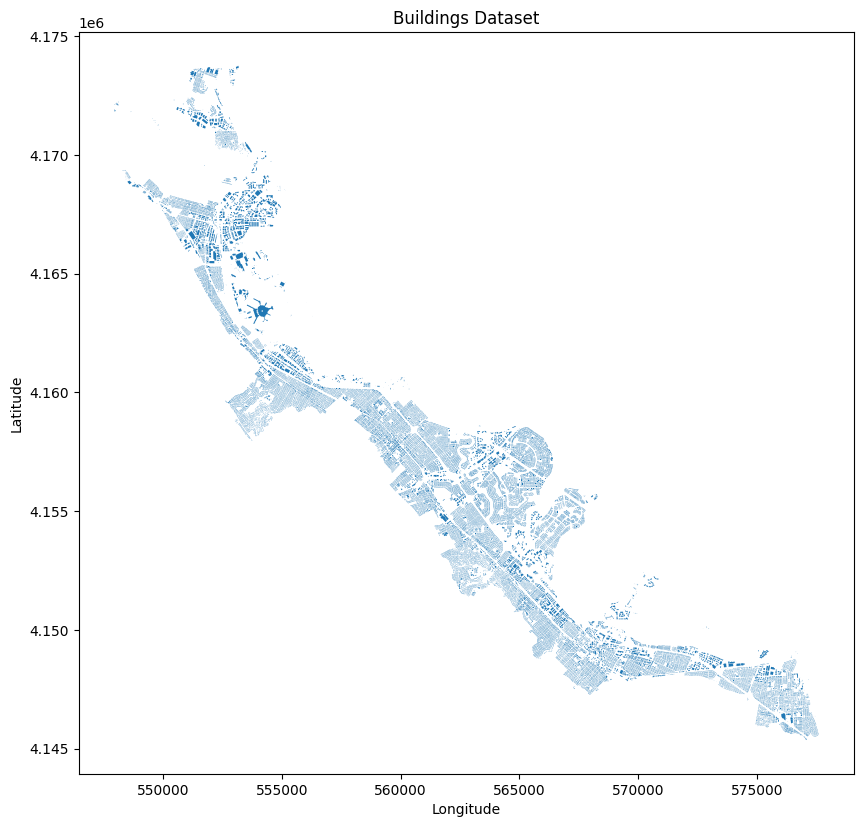

In [396]:
#checkout where the buildings are by mapping them
fig, ax = plt.subplots(figsize=(10, 10))

buildings.plot(ax=ax, edgecolor=None)

plt.title('Buildings Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

We can see from the map that not every building in the county was included in the flood analysis output, and this is because the study looked at only impacted structures (includes residential, commercial, industrial) that intersected with coastal flooding for RCP Scenario 8.5. We now want to merge avoided losses data to the building inventory to spatialize the dataset.

## Merge Avoided Losses csv with Building Footprints shapefile

In [141]:
# Join AAL by building to bring in the geometry of the spatial data of building inventory 
aal_invt = pd.merge(aal, buildings[['OBJECTID','Area_ft','SITUS_CITY','USE_INT','_2020GEOID','APN','geometry']], left_on='buildingID', right_on='OBJECTID', how='left')
aal_invt

,buildingID,RCP85_DP16_AAL_mean,RCP85_DP16_AAL_stdev,RCP60_DP16_AAL_mean,RCP60_DP16_AAL_stdev,RCP45_DP16_AAL_mean,RCP45_DP16_AAL_stdev,RCP26_DP16_AAL_mean,RCP26_DP16_AAL_stdev,RCP85_DP16_2020_EL_mean,RCP85_DP16_2020_EL_stdev,RCP85_DP16_2030_EL_mean,RCP85_DP16_2030_EL_stdev,RCP85_DP16_2040_EL_mean,RCP85_DP16_2040_EL_stdev,RCP85_DP16_2050_EL_mean,RCP85_DP16_2050_EL_stdev,RCP85_DP16_2060_EL_mean,RCP85_DP16_2060_EL_stdev,RCP60_DP16_2020_EL_mean,RCP60_DP16_2020_EL_stdev,RCP60_DP16_2030_EL_mean,RCP60_DP16_2030_EL_stdev,RCP60_DP16_2040_EL_mean,RCP60_DP16_2040_EL_stdev,RCP60_DP16_2050_EL_mean,RCP60_DP16_2050_EL_stdev,RCP60_DP16_2060_EL_mean,RCP60_DP16_2060_EL_stdev,RCP45_DP16_2020_EL_mean,RCP45_DP16_2020_EL_stdev,RCP45_DP16_2030_EL_mean,RCP45_DP16_2030_EL_stdev,RCP45_DP16_2040_EL_mean,RCP45_DP16_2040_EL_stdev,RCP45_DP16_2050_EL_mean,RCP45_DP16_2050_EL_stdev,RCP45_DP16_2060_EL_mean,RCP45_DP16_2060_EL_stdev,RCP26_DP16_2020_EL_mean,RCP26_DP16_2020_EL_stdev,RCP26_DP16_2030_EL_mean,RCP26_DP16_2030_EL_stdev,RCP26_DP16_2040_EL_mean,RCP26_DP16_2040_EL_stdev,RCP26_DP16_2050_EL_mean,RCP26_DP16_2050_EL_stdev,RCP26_DP16_2060_EL_mean,RCP26_DP16_2060_EL_stdev,0_EL_mean,0_EL_stdev,25_EL_mean,25_EL_stdev,50_EL_mean,50_EL_stdev,75_EL_mean,75_EL_stdev,RCP85_DP16_AAL_Stru_mean,RCP85_DP16_AAL_Stru_stdev,RCP60_DP16_AAL_Stru_mean,RCP60_DP16_AAL_Stru_stdev,RCP45_DP16_AAL_Stru_mean,RCP45_DP16_AAL_Stru_stdev,RCP26_DP16_AAL_Stru_mean,RCP26_DP16_AAL_Stru_stdev,RCP85_DP16_2020_EL_Stru_mean,RCP85_DP16_2020_EL_Stru_stdev,RCP85_DP16_2030_EL_Stru_mean,RCP85_DP16_2030_EL_Stru_stdev,RCP85_DP16_2040_EL_Stru_mean,RCP85_DP16_2040_EL_Stru_stdev,RCP85_DP16_2050_EL_Stru_mean,RCP85_DP16_2050_EL_Stru_stdev,RCP85_DP16_2060_EL_Stru_mean,RCP85_DP16_2060_EL_Stru_stdev,RCP60_DP16_2020_EL_Stru_mean,RCP60_DP16_2020_EL_Stru_stdev,RCP60_DP16_2030_EL_Stru_mean,RCP60_DP16_2030_EL_Stru_stdev,RCP60_DP16_2040_EL_Stru_mean,RCP60_DP16_2040_EL_Stru_stdev,RCP60_DP16_2050_EL_Stru_mean,RCP60_DP16_2050_EL_Stru_stdev,RCP60_DP16_2060_EL_Stru_mean,RCP60_DP16_2060_EL_Stru_stdev,RCP45_DP16_2020_EL_Stru_mean,RCP45_DP16_2020_EL_Stru_stdev,RCP45_DP16_2030_EL_Stru_mean,RCP45_DP16_2030_EL_Stru_stdev,RCP45_DP16_2040_EL_Stru_mean,RCP45_DP16_2040_EL_Stru_stdev,RCP45_DP16_2050_EL_Stru_mean,RCP45_DP16_2050_EL_Stru_stdev,RCP45_DP16_2060_EL_Stru_mean,RCP45_DP16_2060_EL_Stru_stdev,RCP26_DP16_2020_EL_Stru_mean,RCP26_DP16_2020_EL_Stru_stdev,RCP26_DP16_2030_EL_Stru_mean,RCP26_DP16_2030_EL_Stru_stdev,RCP26_DP16_2040_EL_Stru_mean,RCP26_DP16_2040_EL_Stru_stdev,RCP26_DP16_2050_EL_Stru_mean,RCP26_DP16_2050_EL_Stru_stdev,RCP26_DP16_2060_EL_Stru_mean,RCP26_DP16_2060_EL_Stru_stdev,0_EL_Stru_mean,0_EL_Stru_stdev,25_EL_Stru_mean,25_EL_Stru_stdev,50_EL_Stru_mean,50_EL_Stru_stdev,75_EL_Stru_mean,75_EL_Stru_stdev,RCP85_DP16_AAL_Cont_mean,RCP85_DP16_AAL_Cont_stdev,RCP60_DP16_AAL_Cont_mean,RCP60_DP16_AAL_Cont_stdev,RCP45_DP16_AAL_Cont_mean,RCP45_DP16_AAL_Cont_stdev,RCP26_DP16_AAL_Cont_mean,RCP26_DP16_AAL_Cont_stdev,RCP85_DP16_2020_EL_Cont_mean,RCP85_DP16_2020_EL_Cont_stdev,RCP85_DP16_2030_EL_Cont_mean,RCP85_DP16_2030_EL_Cont_stdev,RCP85_DP16_2040_EL_Cont_mean,RCP85_DP16_2040_EL_Cont_stdev,RCP85_DP16_2050_EL_Cont_mean,RCP85_DP16_2050_EL_Cont_stdev,RCP85_DP16_2060_EL_Cont_mean,RCP85_DP16_2060_EL_Cont_stdev,RCP60_DP16_2020_EL_Cont_mean,RCP60_DP16_2020_EL_Cont_stdev,RCP60_DP16_2030_EL_Cont_mean,RCP60_DP16_2030_EL_Cont_stdev,RCP60_DP16_2040_EL_Cont_mean,RCP60_DP16_2040_EL_Cont_stdev,RCP60_DP16_2050_EL_Cont_mean,RCP60_DP16_2050_EL_Cont_stdev,RCP60_DP16_2060_EL_Cont_mean,RCP60_DP16_2060_EL_Cont_stdev,RCP45_DP16_2020_EL_Cont_mean,RCP45_DP16_2020_EL_Cont_stdev,RCP45_DP16_2030_EL_Cont_mean,RCP45_DP16_2030_EL_Cont_stdev,RCP45_DP16_2040_EL_Cont_mean,RCP45_DP16_2040_EL_Cont_stdev,RCP45_DP16_2050_EL_Cont_mean,RCP45_DP16_2050_EL_Cont_stdev,RCP45_DP16_2060_EL_Cont_mean,RCP45_DP16_2060_EL_Cont_stdev,RCP26_DP16_2020_EL_Cont_mean,RCP26_DP16_2020_EL_Cont_stdev,RCP26_DP16_2030_EL_Cont_mean,RCP26_DP16_2030_EL_Cont_stdev,RCP26_DP16_2040_EL_Cont_mean,RCP2

In [142]:
# Turn null cities into unincorporated so they don't get dropped later
aal_invt['SITUS_CITY'] = aal_blkgrp['SITUS_CITY'].fillna('UNINCORPORATED')

In [143]:
# We dont need all of these attributes at this point, lets make a subdataframe
sub_aal = aal_invt[['buildingID','APN','RCP85_DP16_AAL_mean','Area_ft','SITUS_CITY','USE_INT','_2020GEOID','geometry']]
sub_aal = gpd.GeoDataFrame(sub_aal, geometry='geometry')

This is our final AAL layer, ready to be merged with the parcel data, since now we have area and damage summed for all buildings in each parcel along with other attributes like city, use code, and block group. 

## Merge Damaged Buildings to Parcel Data at the County Scale

In [144]:
# Examine Parcel data for all of San Mateo County
parcels.head()

,fid,APN,APN2,STATE,COUNTY,FIPS,SIT_HSE_NU,SIT_DIR,SIT_STR_NA,SIT_STR_SF,SIT_FULL_S,SIT_CITY,SIT_STATE,SIT_ZIP,SIT_ZIP4,LAND_VALUE,IMPR_VALUE,TOT_VALUE,ASSMT_YEAR,REC_DATE,SALES_PRIC,YEAR_BUILT,STD_LAND_U,LOT_SIZE,BLDG_AREA,DEED_DSCR,NO_OF_STOR,NO_OF_UNIT,BEDROOMS,BATHROOMS,OWNER,OWNER2,OWNADDRESS,OWNADDRES2,OWNCTYSTZP,XCOORD,YCOORD,MINX,MINY,MAXX,MAXY,MKT_VALUE,ATTDATE,VERSION,QUANTARIUM,impact,geometry
0,1.0,080473999,None,CA,San Mateo,06081,None,None,None,None,None,None,None,None,None,0.0,0.0,0.0,NaN,None,NaN,NaN,None,0.025853,0.0,None,0.000,0.0,0.0,NaN,None,None,None,None,None,-122.211,37.3646,-122.210948,37.364548,-122.210738,37.364638,0.0,20220901,10-11-2022,None,NaN,"POLYGON ((-195525.221 -70176.153, -195524.469 ..."
1,2.0,056230998,None,CA,San Mateo,06081,None,None,None,None,None,None,None,None,None,0.0,0.0,0.0,NaN,None,NaN,NaN,None,0.151364,0.0,None,0.000,0.0,0.0,NaN,None,None,None,None,None,-122.430,37.4693,-122.430786,37.468996,-122.429936,37.469379,0.0,20220901,10-11-2022,None,NaN,"POLYGON ((-214613.088 -58060.839, -214597.721 ..."
2,3.0,053166999,None,CA,San Mateo,06081,310,None,PINE,ST,310 PINE ST,REDWOOD CITY,CA,94063,None,0.0,0.0,0.0,2021.0,None,NaN,NaN,3010,0.090194,0.0,EASTERN ADDITION,0.000,0.0,0.0,0.0,COUNTY OF SAN MATEO,None,455 COUNTY CENTER-5TH FL,None,REDWOOD CITY CA 94063,-122.222,37.4802,-122.221855,37.480025,-122.221613,37.480358,0.0,20220901,10-11-2022,19926531,1.0,"POLYGON ((-196179.965 -57287.151, -196176.053 ..."
3,4.0,055412998,None,CA,San Mateo,06081,None,None,None,None,None,None,None,None,None,0.0,0.0,0.0,NaN,None,NaN,NaN,None,1.104838,0.0,None,0.000,0.0,0.0,NaN,None,None,None,None,None,-122.139,37.4822,-122.139582,37.481885,-122.137855,37.482569,0.0,20220901,10-11-2022,None,NaN,"POLYGON ((-188920.074 -57250.958, -188881.551 ..."
4,5.0,066361999,None,CA,San Mateo,06081,None,None,None,None,None,None,None,None,None,0.0,0.0,0.0,NaN,None,NaN,NaN,None,0.075979,0.0,None,0.000,0.0,0.0,NaN,None,None,None,None,None,-122.431,37.4357,-122.431518,37.435531,-122.431255,37.435857,0.0,20220901,10-11-2022,None,NaN,"POLYGON ((-214817.362 -61814.415, -214824.937 ..."


In [145]:
# Get a sub dataframe for parcels since we don't need all of this information 
sub_parc = parcels[['fid','APN','FIPS','SIT_CITY','LAND_VALUE','IMPR_VALUE','TOT_VALUE','SALES_PRIC','MKT_VALUE','STD_LAND_U','LOT_SIZE','BLDG_AREA','XCOORD','YCOORD','geometry']]
sub_parc = gpd.GeoDataFrame(sub_parc, geometry='geometry')
sub_parc

,fid,APN,FIPS,SIT_CITY,LAND_VALUE,IMPR_VALUE,TOT_VALUE,SALES_PRIC,MKT_VALUE,STD_LAND_U,LOT_SIZE,BLDG_AREA,XCOORD,YCOORD,geometry
0,1.0,080473999,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.025853,0.0,-122.211,37.3646,"POLYGON ((-195525.221 -70176.153, -195524.469 ..."
1,2.0,056230998,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.151364,0.0,-122.430,37.4693,"POLYGON ((-214613.088 -58060.839, -214597.721 ..."
2,3.0,053166999,06081,REDWOOD CITY,0.0,0.0,0.0,NaN,0.0,3010,0.090194,0.0,-122.222,37.4802,"POLYGON ((-196179.965 -57287.151, -196176.053 ..."
3,4.0,055412998,06081,None,0.0,0.0,0.0,NaN,0.0,None,1.104838,0.0,-122.139,37.4822,"POLYGON ((-188920.074 -57250.958, -188881.551 ..."
4,5.0,066361999,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.075979,0.0,-122.431,37.4357,"POLYGON ((-214817.362 -61814.415, -214824.937 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265362,265363.0,-,06081,SAN CARLOS,413237.0,963883.0,1377120.0,1363000.0,0.0,1004,0.960330,1223.0,-122.261,37.5055,"MULTIPOLYGON (((-199607.547 -54433.641, -19965..."
265363,265364.0,-,06081,SAN CARLOS,477900.0,1114073.0,1591973.0,1578000.0,0.0,1004,0.960330,1497.0,-122.261,37.5055,"MULTIPOLYGON (((-199607.547 -54433.641, -19965..."
265364,265365.0,-,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.002128,0.0,-122.202,37.4308,"POLYGON ((-194555.447 -62835.864, -194556.046 ..."
265365,265366.0,027042998,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.015500,0.0,-122.397,37.5740,"POLYGON ((-211398.067 -46512.010, -211409.104 ..."


In [146]:
# Before the spatial join make sure they are in the same CRS
sub_aal = sub_aal.to_crs(crs)
sub_parc = sub_parc.to_crs(crs)

In [147]:
# Perform spatial join to identify overlapping parcels
aal_parcels = gpd.sjoin(sub_aal, sub_parc, how='left', op='intersects')

# Calculate area of overlap for each building-parcel pair
aal_parcels['area_of_overlap'] = aal_parcels.geometry.intersection(aal_parcels.geometry).area

# Identify the row with the greatest overlap for each building
largest_overlap_indices = aal_parcels.groupby(aal_parcels.index)['area_of_overlap'].idxmax()

# Keep only rows with the greatest overlap for each building
aal_parcels = aal_parcels.loc[largest_overlap_indices]

# Drop duplicate rows based on the index of the left GeoDataFrame (sub_aal)
aal_parcels = aal_parcels[~aal_parcels.index.duplicated(keep='first')]

In [148]:
#Check to make sure join was properly performed, and that buildings assigned to parcel with greatest overlap
print(aal_parcels['RCP85_DP16_AAL_mean'].sum() == sub_aal['RCP85_DP16_AAL_mean'].sum())
print(aal_parcels.shape[0] == sub_aal.shape[0]) 

True
True


In [149]:
# Group the joined data by parcel lot FID so we can join it back to the original parcels dataset
fid_aal = aal_parcels.groupby('fid').agg({
    'RCP85_DP16_AAL_mean':'sum',
    'Area_ft':'sum',
    'SITUS_CITY': lambda x: mode(x),
    'USE_INT': lambda x: mode(x),
    })

fid_aal

,RCP85_DP16_AAL_mean,Area_ft,SITUS_CITY,USE_INT
fid,,,,
20.0,516432.58,9877.969482,REDWOOD CITY,1
115.0,0.00,5383.588379,SOUTH SAN FRANCISCO,6
130.0,0.00,5783.132324,SOUTH SAN FRANCISCO,23
133.0,0.00,14424.522461,SOUTH SAN FRANCISCO,38
150.0,48988.34,31130.994141,BURLINGAME,31
...,...,...,...,...
265069.0,2399201.47,73377.485840,FOSTER CITY,5
265076.0,218041.94,10165.375793,FOSTER CITY,5
265081.0,106436.31,6701.820801,FOSTER CITY,5


In [156]:
smc_parcels = pd.merge(sub_parc, fid_aal, left_on='fid', right_on='fid', how='left')
smc_parcels

,fid,APN,FIPS,SIT_CITY,LAND_VALUE,IMPR_VALUE,TOT_VALUE,SALES_PRIC,MKT_VALUE,STD_LAND_U,LOT_SIZE,BLDG_AREA,XCOORD,YCOORD,geometry,RCP85_DP16_AAL_mean,Area_ft,SITUS_CITY,USE_INT
0,1.0,080473999,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.025853,0.0,-122.211,37.3646,"POLYGON ((-195525.221 -70176.153, -195524.469 ...",NaN,NaN,NaN,NaN
1,2.0,056230998,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.151364,0.0,-122.430,37.4693,"POLYGON ((-214613.088 -58060.839, -214597.721 ...",NaN,NaN,NaN,NaN
2,3.0,053166999,06081,REDWOOD CITY,0.0,0.0,0.0,NaN,0.0,3010,0.090194,0.0,-122.222,37.4802,"POLYGON ((-196179.965 -57287.151, -196176.053 ...",NaN,NaN,NaN,NaN
3,4.0,055412998,06081,None,0.0,0.0,0.0,NaN,0.0,None,1.104838,0.0,-122.139,37.4822,"POLYGON ((-188920.074 -57250.958, -188881.551 ...",NaN,NaN,NaN,NaN
4,5.0,066361999,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.075979,0.0,-122.431,37.4357,"POLYGON ((-214817.362 -61814.415, -214824.937 ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265362,265363.0,-,06081,SAN CARLOS,413237.0,963883.0,1377120.0,1363000.0,0.0,1004,0.960330,1223.0,-122.261,37.5055,"MULTIPOLYGON (((-199607.547 -54433.641, -19965...",NaN,NaN,NaN,NaN
265363,265364.0,-,06081,SAN CARLOS,477900.0,1114073.0,1591973.0,1578000.0,0.0,1004,0.960330,1497.0,-122.261,37.5055,"MULTIPOLYGON (((-199607.547 -54433.641, -19965...",NaN,NaN,NaN,NaN
265364,265365.0,-,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.002128,0.0,-122.202,37.4308,"POLYGON ((-194555.447 -62835.864, -194556.046 ...",NaN,NaN,NaN,NaN
265365,265366.0,027042998,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.015500,0.0,-122.397,37.5740,"POLYGON ((-211398.067 -46512.010, -211409.104 ...",NaN,NaN,NaN,NaN


In [151]:
#checking again aal was preserved in the join 
print(smc_parcels['RCP85_DP16_AAL_mean'].sum())
print(fid_aal['RCP85_DP16_AAL_mean'].sum())

2046930010.52
2046930010.5200002


The last preprocessing step is to clear up what the structure use codes are in our parcel dataset so they are more human-readable. 

In [168]:
#merge land use codes with final parcel dataset
smc_parcels = pd.merge(smc_parcels, use_codes, left_on='STD_LAND_U', right_on='Use_Code', how='left')
smc_parcels.head()

,fid,APN,FIPS,SIT_CITY,LAND_VALUE,IMPR_VALUE,TOT_VALUE,SALES_PRIC,MKT_VALUE,STD_LAND_U,LOT_SIZE,BLDG_AREA,XCOORD,YCOORD,geometry,RCP85_DP16_AAL_mean,Area_ft,SITUS_CITY,USE_INT,Use_Code,Use_Description,Use_Type
0,1.0,080473999,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.025853,0.0,-122.211,37.3646,"POLYGON ((-195525.221 -70176.153, -195524.469 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,056230998,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.151364,0.0,-122.430,37.4693,"POLYGON ((-214613.088 -58060.839, -214597.721 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,053166999,06081,REDWOOD CITY,0.0,0.0,0.0,NaN,0.0,3010,0.090194,0.0,-122.222,37.4802,"POLYGON ((-196179.965 -57287.151, -196176.053 ...",NaN,NaN,NaN,NaN,3010,Mixed Use (Commercial/Industrial),Mixed
3,4.0,055412998,06081,None,0.0,0.0,0.0,NaN,0.0,None,1.104838,0.0,-122.139,37.4822,"POLYGON ((-188920.074 -57250.958, -188881.551 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,066361999,06081,None,0.0,0.0,0.0,NaN,0.0,None,0.075979,0.0,-122.431,37.4357,"POLYGON ((-214817.362 -61814.415, -214824.937 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
#create an impact flag for each parcel if AAL > 0
smc_parcels['impact'] = (smc_parcels['RCP85_DP16_AAL_mean'] > 0).astype(int)

In [251]:
#let's now calculate AAL as a proportion of total Assessed Value
smc_parcels['pct_aal_av'] = smc_parcels['RCP85_DP16_AAL_mean'] / smc_parcels['TOT_VALUE']
smc_parcels['pct_aal_av'] = smc_parcels['pct_aal_av'].replace(np.inf, np.nan)

In [399]:
#let's export to make this dataset easier to use next time
smc_parcels.to_file("/Volumes/Emmalina_external/CAPSTONE/Bay_Area/Final_Layers/smc_aal_parcels.shp")

Now we have our final parcels dataset! Let's examine some interesting information about assessed value and flood losses at the parcel level...

## Visualizing Indicators by Land Use

In [179]:
print('The percentage of parcels with no assessed value data is',sum(smc_parcels['TOT_VALUE'] == 0.0)/smc_parcels.shape[0])
print('The percentage of parcels with no structure use codes is',sum(smc_parcels['Use_Type'].isnull())/smc_parcels.shape[0])
print('The percentage of parcels with no city identifier is',sum(smc_parcels['SIT_CITY'].isnull())/smc_parcels.shape[0])

The percentage of parcels with no assessed value data is 0.1665542437454544
The percentage of parcels with no structure use codes is 0.155207693496177
The percentage of parcels with no city identifier is 0.1591079523829263


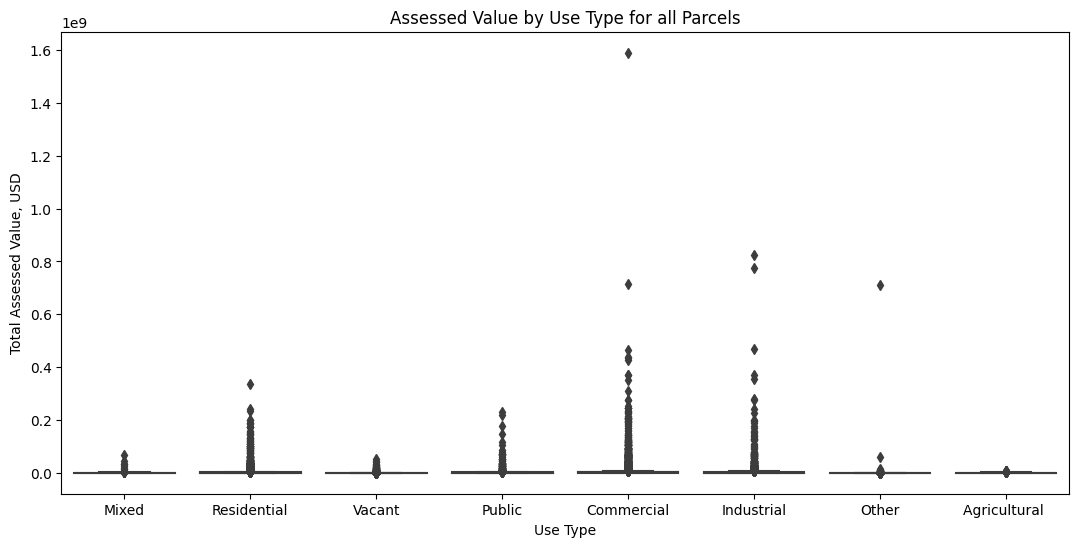

In [195]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(data=smc_parcels, x='Use_Type', y='TOT_VALUE',ax=ax)
ax.set_xlabel('Use Type')
ax.set_ylabel('Total Assessed Value, USD')
ax.set_title('Assessed Value by Use Type for all Parcels')
plt.show()

We can see industrial and commercial sites have the more outliers, making the distribution right skewed. Let's try looking at it by establishing a assessed value ceiling so it's more readable. 

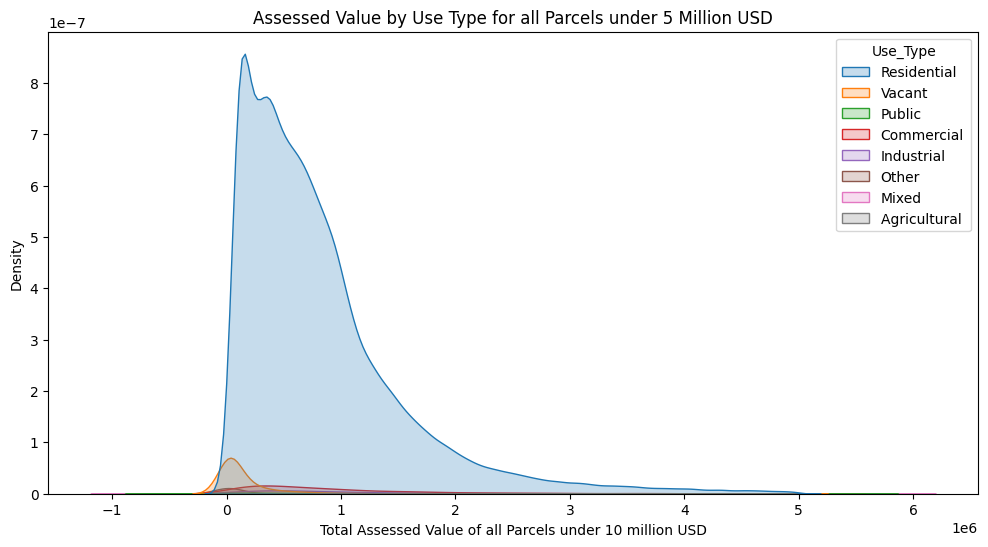

In [223]:
fig, ax = plt.subplots(figsize=(12,6))
sns.kdeplot(data=smc_parcels[(smc_parcels['TOT_VALUE'] <= 5000000) & (smc_parcels['TOT_VALUE'] > 0)], x="TOT_VALUE", hue='Use_Type', fill=True, ax=ax)
ax.set_xlabel('Total Assessed Value of all Parcels under 10 million USD')
ax.set_title('Assessed Value by Use Type for all Parcels under 5 Million USD')
plt.show()

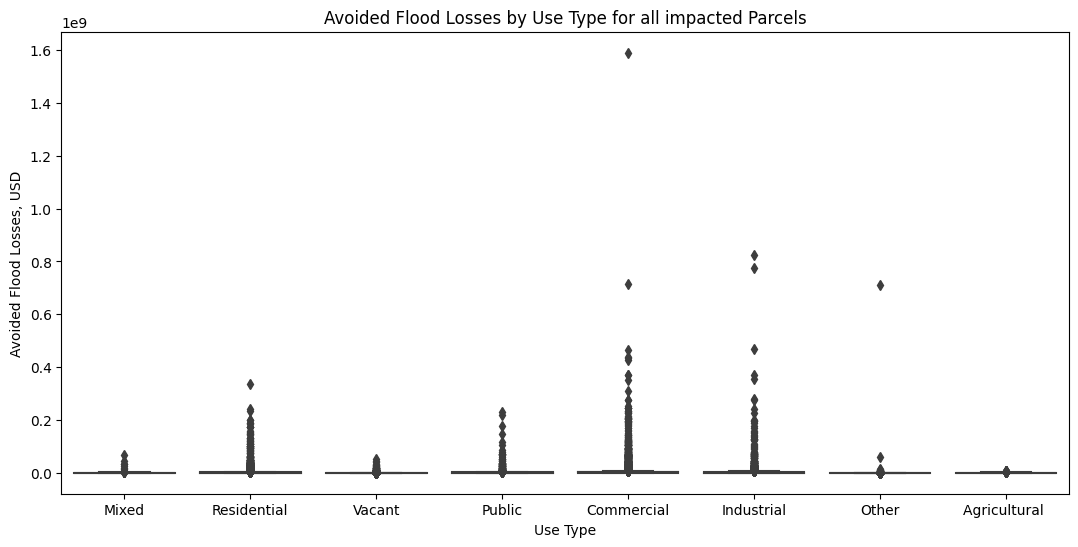

In [218]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.boxplot(data=smc_parcels, x='Use_Type', y='TOT_VALUE',ax=ax)
ax.set_xlabel('Use Type')
ax.set_ylabel('Avoided Flood Losses, USD')
ax.set_title('Avoided Flood Losses by Use Type for all impacted Parcels')
plt.show()

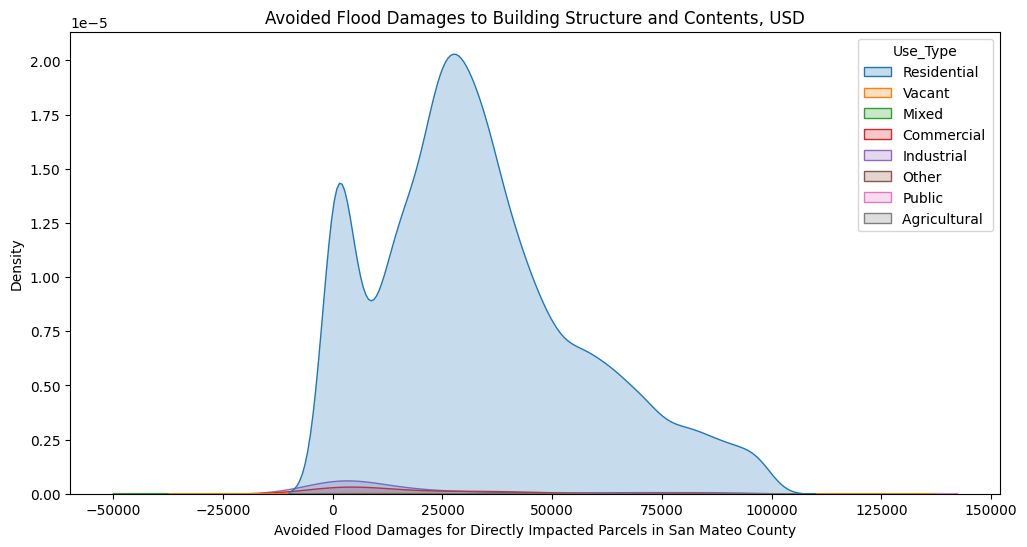

In [224]:
fig, ax = plt.subplots(figsize=(12,6))
sns.kdeplot(data=smc_parcels[(smc_parcels['RCP85_DP16_AAL_mean'] > 0) & (smc_parcels['RCP85_DP16_AAL_mean'] <= 100000)], x='RCP85_DP16_AAL_mean', hue='Use_Type', fill=True, ax=ax)
ax.set_xlabel('Avoided Flood Damages for Directly Impacted Parcels in San Mateo County')
ax.set_title('Avoided Flood Damages to Building Structure and Contents, USD')
plt.show()

Let's look at Assessed Value and Flood Impact together by Use Code:

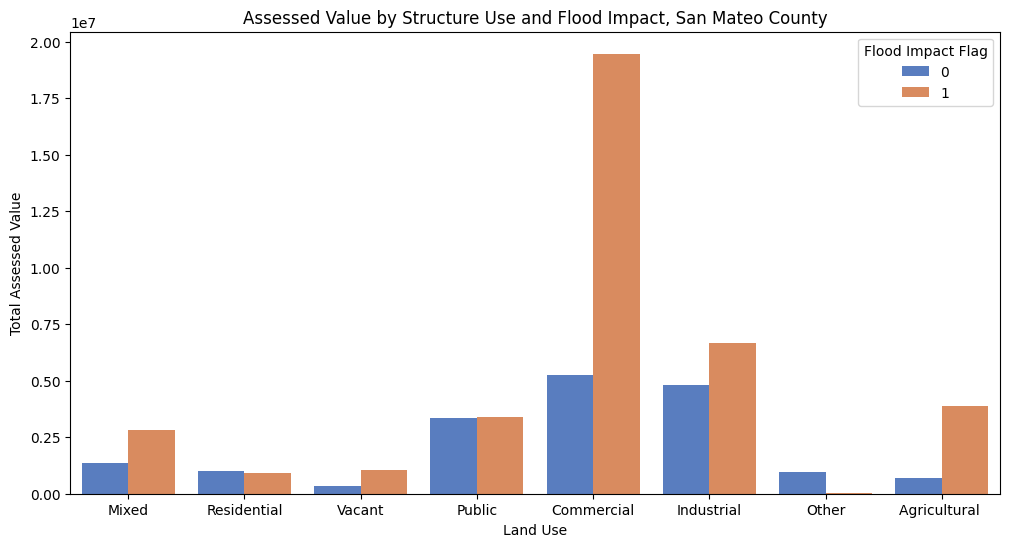

In [243]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=smc_parcels, x='Use_Type', y='TOT_VALUE', hue='impact', palette='muted', ci=None)

plt.xlabel('Land Use')
plt.ylabel('Total Assessed Value')
plt.legend(title='Flood Impact Flag')
plt.title('Assessed Value by Structure Use and Flood Impact, San Mateo County')

plt.show()

Looking at Assessed Value and Flood Damage Distribution by Land Use above, we can see that the majority of impacts are in reidential structures, despite outliers creating a left tail skew in commercial and residential. We also see in this last graph that total assessed value "at risk" of flood damage is higher in commercial areas, however, we have exact flood damage estimates, so let's look at the whole picture:

In [287]:
# Let's look at some of our indicators of interest by use type
use_grouped = (smc_parcels.groupby('Use_Type')[['Use_Type','TOT_VALUE','RCP85_DP16_AAL_mean','LOT_SIZE','BLDG_AREA','impact']]
               .agg({
                   'TOT_VALUE':'sum',
                   'RCP85_DP16_AAL_mean':'sum',
                   'LOT_SIZE':'sum',
                   'BLDG_AREA':'sum',
                   'impact':'sum',
                   'Use_Type':'size'})
               .rename(columns={'Use_Type':'Count'})
               .sort_values(by=['TOT_VALUE','RCP85_DP16_AAL_mean'], ascending=False))

use_grouped['pct_impact'] = use_grouped['RCP85_DP16_AAL_mean'] / use_grouped['TOT_VALUE']
use_grouped

,TOT_VALUE,RCP85_DP16_AAL_mean,LOT_SIZE,BLDG_AREA,impact,Count,pct_impact
Use_Type,,,,,,,
Residential,2.011169e+11,9.778744e+08,235604.521418,419049954.0,17587,204595,0.004862
Commercial,4.158783e+10,4.903332e+08,24722.080893,72188470.0,476,6615,0.011790
Industrial,1.723026e+10,1.387333e+08,11646.087782,35510932.0,532,3364,0.008052
Public,3.994132e+09,3.448289e+07,21708.350909,480916.0,75,1193,0.008633
Vacant,2.394329e+09,9.384054e+07,160797.597871,349164.0,62,6724,0.039193
Other,9.649687e+08,1.823803e+07,170980.519236,37359.0,25,1025,0.018900
Mixed,3.393268e+08,6.419857e+06,1711.110383,1160378.0,27,218,0.018919
Agricultural,3.120602e+08,2.816740e+05,63251.529660,188067.0,2,446,0.000903


This ranking helps us see residential structures make up the *majority* of total parcel types, total assessed value, total avoided flood losses, and total area, both in terms of parcel lot size and building volume in San Mateo County.

## Visualizing Indicators by Municipality

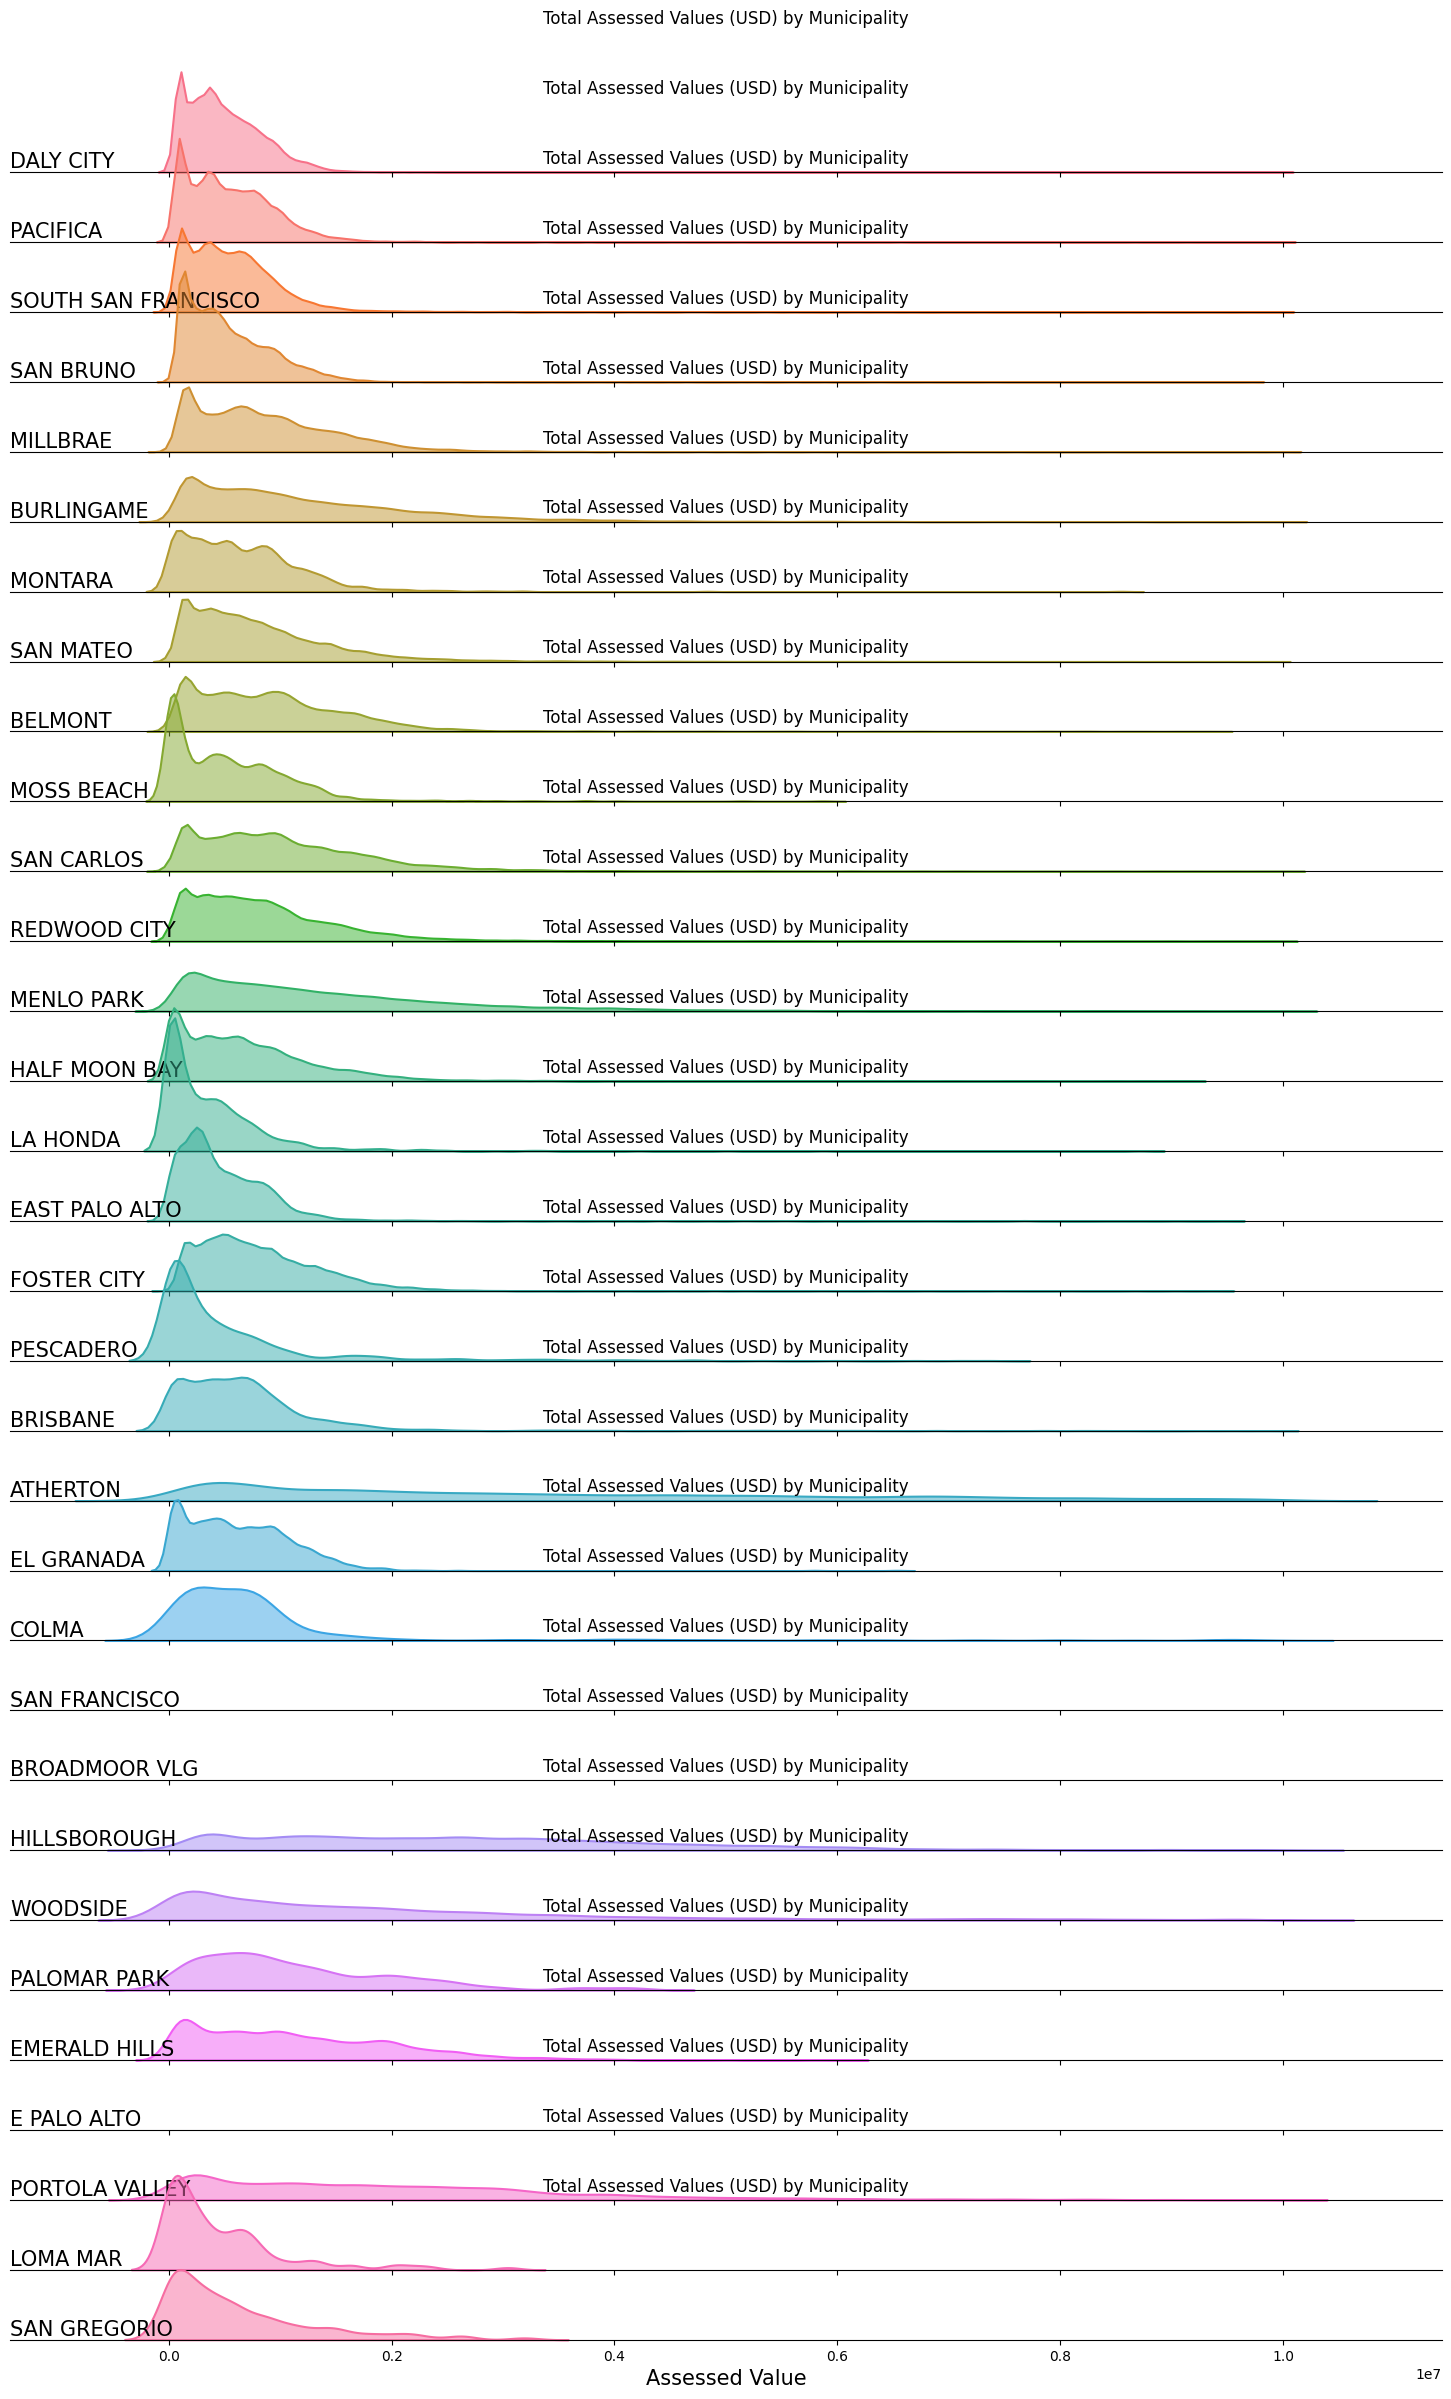

In [206]:
from matplotlib import rcParams

with sns.axes_style({"style": "white", "axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(smc_parcels[(smc_parcels['TOT_VALUE'] <= 10000000) & (smc_parcels['TOT_VALUE'] > 0)], row="SIT_CITY", hue="SIT_CITY", aspect=20, height=.75)
    g.map(sns.kdeplot, "TOT_VALUE",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=.5, linewidth=1.5)
    g.figure.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[])
    g.despine( left=True)
    g.set_axis_labels("Assessed Value", "", fontsize=15)
    g.set_titles(row_template='{row_name}')
    for ax in g.axes:
        title = ax[0].get_title()
        ax[0].set_title("Total Assessed Values (USD) by Municipality")
        ax[0].set_ylabel(title, rotation=0, loc='bottom', labelpad=0)
        

We can see which municipalities have higher assessed values, usually indicative of a wealthier and higher tax base.

In [300]:
# Let's look at some of our indicators of interest by municipality
city_grouped = (smc_parcels.groupby('SIT_CITY')[['SIT_CITY','TOT_VALUE','RCP85_DP16_AAL_mean','LOT_SIZE','BLDG_AREA','impact']]
               .agg({
                   'TOT_VALUE':'sum',
                   'RCP85_DP16_AAL_mean':'sum',
                   'LOT_SIZE':'sum',
                   'BLDG_AREA':'sum',
                   'impact':'sum',
                   'SIT_CITY':'size'})
               .rename(columns={'SIT_CITY':'Count'})
               .sort_values(by=['RCP85_DP16_AAL_mean','TOT_VALUE'], ascending=False))
city_grouped['pct_impact'] = city_grouped['RCP85_DP16_AAL_mean'] / city_grouped['TOT_VALUE']
city_grouped

,TOT_VALUE,RCP85_DP16_AAL_mean,LOT_SIZE,BLDG_AREA,impact,Count,pct_impact
SIT_CITY,,,,,,,
REDWOOD CITY,3.278773e+10,6.900054e+08,24494.911393,68269171.0,3088,25511,0.021045
FOSTER CITY,1.423751e+10,5.021698e+08,13598.487787,28494487.0,5579,9620,0.035271
SAN MATEO,3.487180e+10,3.142898e+08,127199.689970,75362569.0,7292,32928,0.009013
SAN CARLOS,1.476708e+10,8.582046e+07,7719.356379,26752713.0,223,12192,0.005812
MENLO PARK,2.831639e+10,6.423062e+07,9163.109881,38960433.0,528,13269,0.002268
BURLINGAME,1.522282e+10,4.810717e+07,6251.395904,29707112.0,173,9462,0.003160
EAST PALO ALTO,3.987060e+09,4.710604e+07,1552.022581,10226324.0,1410,5007,0.011815
MILLBRAE,6.526149e+09,5.252950e+06,3126.217039,14907088.0,99,6900,0.000805
SAN BRUNO,9.128462e+09,1.123564e+06,56471.957095,22704423.0,1,12609,0.000123


We can start to see a ranking of which municipalities face the highest damages, and what annual percentage of their assessed value this poses. This will be important when looking at social vulnerability next. Finally, let's look at a scatter plot of parcel by parcel attributes:

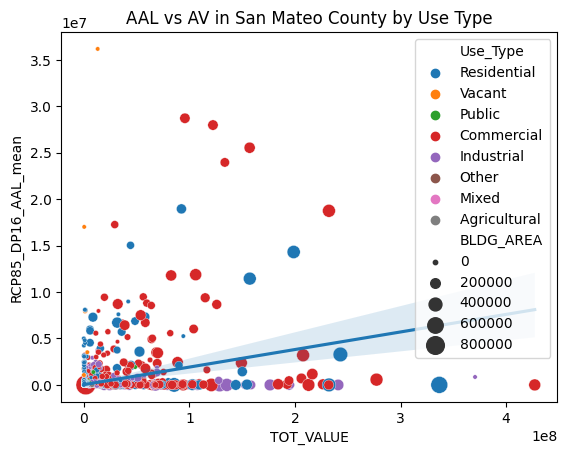

In [417]:
to_plot = smc_parcels[smc_parcels['TOT_VALUE'] > 0]

sns.scatterplot(x='TOT_VALUE', y='RCP85_DP16_AAL_mean', data=to_plot, 
                hue='Use_Type', size='BLDG_AREA', sizes=(10, 200))

plt.xlabel('Total Assessed Value (USD)')
plt.ylabel('Average Annual Avoided Flood Losses (USD)')
plt.title('AAL vs AV in San Mateo County by Use Type')

plt.legend()

sns.regplot(x='TOT_VALUE', y='RCP85_DP16_AAL_mean', data=to_plot, scatter=False)

# Show plot
plt.show()

Assessed Value might be correlated to potential flood damages, but we know this (1) could be because larger AV means larger area of buildings, so more damages, and (2) this is very locationally specific, and due to proximity to hazard, so trends should be taken lightly.

## Pull in Community Vulnerability Data via ArcGIS API and examine outputs

This data is from the Bay Coastal Development Commission (BCDC), which can be found at this [link.](https://services2.arcgis.com/4Z9x989NrBVrvFwm/arcgis/rest/services/Community_Vulnerability_2023_Update_WFL1/FeatureServer) The data is pulled from the ArcGIS REST API below.

In [180]:
from arcgis import GIS

#Connect to AGOL 
gis = GIS()

#Load the feature layer by its URL
item = gis.content.get("4754f012d32f4a2d881b9816af0832c7")
layer = item.layers[0]

features = layer.query()
vuln = features.sdf

vuln.head()

,OBJECTID,GEOID,NAME,TRACTID_x,TRACTID_y,socVuln70,socVuln90,ind_70pct,ind_90pct,socVulnRank,estimate_totPop,estimate_totHH,estimate_AveHHSize,estimate_renter,estimate_under5,estimate_noVeh,estimate_disabHH,estimate_SglPar,estimate_PoC,estimate_65Alone,estimate_noHS,estimate_MortgageHCB,estimate_LEP_HH,estimate_B200Pv,estimate_RentHCB,estimate_NoCtz,estimate_50MedianAMI,moe_totPop,moe_totHH,moe_AveHHSize,moe_renter,moe_under5,moe_noVeh,moe_disabHH,moe_SglPar,moe_PoC,moe_65Alone,moe_noHS,moe_MortgageHCB,moe_LEP_HH,moe_B200Pv,moe_RentHCB,moe_NoCtz,moe_50MedianAMI,pct_renter,pct_under5,pct_noVeh,pct_disabHH,pct_SglPar,pct_PoC,pct_65Alone,pct_noHS,pct_MortgageHCB,pct_LEP_HH,pct_B200Pv,pct_RentHCB,pct_NoCtz,pct_50MedianAMI,pct_moe_renter,pct_moe_under5,pct_moe_noVeh,pct_moe_disabHH,pct_moe_SglPar,pct_moe_PoC,pct_moe_65Alone,pct_moe_noHS,pct_moe_MortgageHCB,pct_moe_LEP_HH,pct_moe_B200Pv,pct_moe_RentHCB,pct_moe_NoCtz,pct_moe_50MedianAMI,flag70_renter,flag70_under5,flag70_noVeh,flag70_disabHH,flag70_SglPar,flag70_PoC,flag70_65Alone,flag70_noHS,flag70_LEP_HH,flag70_NoCtz,flag70_HCB,flag70_VLowInc,flag90_renter,flag90_under5,flag90_noVeh,flag90_disabHH,flag90_SglPar,flag90_PoC,flag90_65Alone,flag90_noHS,flag90_LEP_HH,flag90_NoCtz,flag90_HCB,flag90_VLowInc,estimate_ForBrn,estimate_LEP_Spanish,estimate_LEP_Chinese,estimate_LEP_Vietnms,estimate_LEP_Tagalog,moe_ForBrn,moe_LEP_Spanish,moe_LEP_Chinese,moe_LEP_Vietnms,moe_LEP_Tagalog,pct_ForBrn,pct_LEP_Spanish,pct_LEP_Chinese,pct_LEP_Vietnms,pct_LEP_Tagalog,pct_moe_ForBrn,pct_moe_LEP_Spanish,pct_moe_LEP_Chinese,pct_moe_LEP_Vietnms,pct_moe_LEP_Tagalog,estimate_Latino,estimate_Black,estimate_AmIndn,estimate_Asian,estimate_Island,estimate_OthRac,estimate_TwoRac,estimate_Under10,estimate_Under18,moe_Latino,moe_Black,moe_AmIndn,moe_Asian,moe_Island,moe_OthRac,moe_TwoRac,moe_Under10,moe_Under18,pct_Latino,pct_Black,pct_AmIndn,pct_Asian,pct_Island,pct_OthRac,pct_TwoRac,pct_Under10,pct_Under18,pct_moe_Latino,pct_moe_Black,pct_moe_AmIndn,pct_moe_Asian,pct_moe_Island,pct_moe_OthRac,pct_moe_TwoRac,pct_moe_Under10,pct_moe_Under18,MTC_CoC_2018,displcType,CES4_pctl,Clean_pctl,GW_pctl,Haz_pct,IWB_pctl,Solid_pctl,PDA_Name,PDA_ID,contam70,contam90,contamVulnRank,contam_ind_70pct,contam_ind_90pct,centroid_lng,centroid_lat,SUM_res_units_2010_exp_12,SUM_res_units_2040_exp_12,SUM_job_spaces_2010_exp_12,SUM_job_spaces_2040_exp_12,SUM_res_units_2010_exp_24,SUM_res_units_2040_exp_24,SUM_job_spaces_2010_exp_24,SUM_job_spaces_2040_exp_24,SUM_res_units_2010_exp_36,SUM_res_units_2040_exp_36,SUM_job_spaces_2010_exp_36,SUM_job_spaces_2040_exp_36,SUM_res_units_2010_exp_48,SUM_res_units_2040_exp_48,SUM_job_spaces_2010_exp_48,SUM_job_spaces_2040_exp_48,SUM_res_units_2010_exp_52,SUM_res_units_2040_exp_52,SUM_job_spaces_2010_exp_52,SUM_job_spaces_2040_exp_52,SUM_res_units_2010_exp_66,SUM_res_units_2040_exp_66,SUM_job_spaces_2010_exp_66,SUM_job_spaces_2040_exp_66,SUM_res_units_2010_exp_77,SUM_res_units_2040_exp_77,SUM_job_spaces_2010_exp_77,SUM_job_spaces_2040_exp_77,SUM_res_units_2010_exp_84,SUM_res_units_2040_exp_84,SUM_job_spaces_2010_exp_84,SUM_job_spaces_2040_exp_84,SUM_res_units_2010_exp_96,SUM_res_units_2040_exp_96,SUM_job_spaces_2010_exp_96,SUM_job_spaces_2040_exp_96,SUM_res_units_2010_exp_108,SUM_res_units_2040_exp_108,SUM_job_spaces_2010_exp_108,SUM_job_spaces_2040_exp_108,SUM_res_units_2010_exp_FEMA100,SUM_res_units_2040_exp_FEMA100,SUM_job_spaces_2010_exp_FEMA100,SUM_job_spaces_2040_exp_FEMA100,SUM_res_units_2010_exp_FEMA500,SUM_res_units_2040_exp_FEMA500,SUM_job_spaces_2010_exp_FEMA500,SUM_job_spaces_2040_exp_FEMA500,SUM_res_units_2010_exp_SFPrecip,SUM_res_units_2040_exp_SFPrecip,SUM_job_spaces_2010_exp_SFPreci,SUM_job_spaces_2040_exp_SFPreci,SUM_total_residential_units_201,SUM_total_residential_units_204,SUM_total_job_spaces_2010_Total,SUM_total_job_spaces_2040_Total,socVulnRank2020,contamVulnRank2020,soc_diff_val,contam_diff_val,combined_vulnerability,Shape__Area,Shape__Length,SHAPE
0,1,060014283023,"Block Group 3

In [327]:
#convert the df to a gdf
vuln = gpd.GeoDataFrame(vuln, geometry='SHAPE', crs="EPSG:26910").to_crs(crs)
vuln.head()

,OBJECTID,GEOID,NAME,TRACTID_x,TRACTID_y,socVuln70,socVuln90,ind_70pct,ind_90pct,socVulnRank,estimate_totPop,estimate_totHH,estimate_AveHHSize,estimate_renter,estimate_under5,estimate_noVeh,estimate_disabHH,estimate_SglPar,estimate_PoC,estimate_65Alone,estimate_noHS,estimate_MortgageHCB,estimate_LEP_HH,estimate_B200Pv,estimate_RentHCB,estimate_NoCtz,estimate_50MedianAMI,moe_totPop,moe_totHH,moe_AveHHSize,moe_renter,moe_under5,moe_noVeh,moe_disabHH,moe_SglPar,moe_PoC,moe_65Alone,moe_noHS,moe_MortgageHCB,moe_LEP_HH,moe_B200Pv,moe_RentHCB,moe_NoCtz,moe_50MedianAMI,pct_renter,pct_under5,pct_noVeh,pct_disabHH,pct_SglPar,pct_PoC,pct_65Alone,pct_noHS,pct_MortgageHCB,pct_LEP_HH,pct_B200Pv,pct_RentHCB,pct_NoCtz,pct_50MedianAMI,pct_moe_renter,pct_moe_under5,pct_moe_noVeh,pct_moe_disabHH,pct_moe_SglPar,pct_moe_PoC,pct_moe_65Alone,pct_moe_noHS,pct_moe_MortgageHCB,pct_moe_LEP_HH,pct_moe_B200Pv,pct_moe_RentHCB,pct_moe_NoCtz,pct_moe_50MedianAMI,flag70_renter,flag70_under5,flag70_noVeh,flag70_disabHH,flag70_SglPar,flag70_PoC,flag70_65Alone,flag70_noHS,flag70_LEP_HH,flag70_NoCtz,flag70_HCB,flag70_VLowInc,flag90_renter,flag90_under5,flag90_noVeh,flag90_disabHH,flag90_SglPar,flag90_PoC,flag90_65Alone,flag90_noHS,flag90_LEP_HH,flag90_NoCtz,flag90_HCB,flag90_VLowInc,estimate_ForBrn,estimate_LEP_Spanish,estimate_LEP_Chinese,estimate_LEP_Vietnms,estimate_LEP_Tagalog,moe_ForBrn,moe_LEP_Spanish,moe_LEP_Chinese,moe_LEP_Vietnms,moe_LEP_Tagalog,pct_ForBrn,pct_LEP_Spanish,pct_LEP_Chinese,pct_LEP_Vietnms,pct_LEP_Tagalog,pct_moe_ForBrn,pct_moe_LEP_Spanish,pct_moe_LEP_Chinese,pct_moe_LEP_Vietnms,pct_moe_LEP_Tagalog,estimate_Latino,estimate_Black,estimate_AmIndn,estimate_Asian,estimate_Island,estimate_OthRac,estimate_TwoRac,estimate_Under10,estimate_Under18,moe_Latino,moe_Black,moe_AmIndn,moe_Asian,moe_Island,moe_OthRac,moe_TwoRac,moe_Under10,moe_Under18,pct_Latino,pct_Black,pct_AmIndn,pct_Asian,pct_Island,pct_OthRac,pct_TwoRac,pct_Under10,pct_Under18,pct_moe_Latino,pct_moe_Black,pct_moe_AmIndn,pct_moe_Asian,pct_moe_Island,pct_moe_OthRac,pct_moe_TwoRac,pct_moe_Under10,pct_moe_Under18,MTC_CoC_2018,displcType,CES4_pctl,Clean_pctl,GW_pctl,Haz_pct,IWB_pctl,Solid_pctl,PDA_Name,PDA_ID,contam70,contam90,contamVulnRank,contam_ind_70pct,contam_ind_90pct,centroid_lng,centroid_lat,SUM_res_units_2010_exp_12,SUM_res_units_2040_exp_12,SUM_job_spaces_2010_exp_12,SUM_job_spaces_2040_exp_12,SUM_res_units_2010_exp_24,SUM_res_units_2040_exp_24,SUM_job_spaces_2010_exp_24,SUM_job_spaces_2040_exp_24,SUM_res_units_2010_exp_36,SUM_res_units_2040_exp_36,SUM_job_spaces_2010_exp_36,SUM_job_spaces_2040_exp_36,SUM_res_units_2010_exp_48,SUM_res_units_2040_exp_48,SUM_job_spaces_2010_exp_48,SUM_job_spaces_2040_exp_48,SUM_res_units_2010_exp_52,SUM_res_units_2040_exp_52,SUM_job_spaces_2010_exp_52,SUM_job_spaces_2040_exp_52,SUM_res_units_2010_exp_66,SUM_res_units_2040_exp_66,SUM_job_spaces_2010_exp_66,SUM_job_spaces_2040_exp_66,SUM_res_units_2010_exp_77,SUM_res_units_2040_exp_77,SUM_job_spaces_2010_exp_77,SUM_job_spaces_2040_exp_77,SUM_res_units_2010_exp_84,SUM_res_units_2040_exp_84,SUM_job_spaces_2010_exp_84,SUM_job_spaces_2040_exp_84,SUM_res_units_2010_exp_96,SUM_res_units_2040_exp_96,SUM_job_spaces_2010_exp_96,SUM_job_spaces_2040_exp_96,SUM_res_units_2010_exp_108,SUM_res_units_2040_exp_108,SUM_job_spaces_2010_exp_108,SUM_job_spaces_2040_exp_108,SUM_res_units_2010_exp_FEMA100,SUM_res_units_2040_exp_FEMA100,SUM_job_spaces_2010_exp_FEMA100,SUM_job_spaces_2040_exp_FEMA100,SUM_res_units_2010_exp_FEMA500,SUM_res_units_2040_exp_FEMA500,SUM_job_spaces_2010_exp_FEMA500,SUM_job_spaces_2040_exp_FEMA500,SUM_res_units_2010_exp_SFPrecip,SUM_res_units_2040_exp_SFPrecip,SUM_job_spaces_2010_exp_SFPreci,SUM_job_spaces_2040_exp_SFPreci,SUM_total_residential_units_201,SUM_total_residential_units_204,SUM_total_job_spaces_2010_Total,SUM_total_job_spaces_2040_Total,socVulnRank2020,contamVulnRank2020,soc_diff_val,contam_diff_val,combined_vulnerability,Shape__Area,Shape__Length,SHAPE
0,1,060014283023,"Block Group 3

In [330]:
# Check for proportion of rows with valid geometries
print(sum(vuln.is_valid)/vuln.shape[0])

# Drop invalid geometries
vuln = vuln[vuln.is_valid]

0
0.9665958679281714


In [339]:
#check the datatypes for mapping cloropleths
vuln.dtypes

OBJECTID                              Int64
GEOID                                string
NAME                                 string
TRACTID_x                            string
TRACTID_y                            string
socVuln70                           Float64
socVuln90                           Float64
ind_70pct                            string
ind_90pct                            string
socVulnRank                          string
estimate_totPop                     Float64
estimate_totHH                      Float64
estimate_AveHHSize                  Float64
estimate_renter                     Float64
estimate_under5                     Float64
estimate_noVeh                      Float64
estimate_disabHH                    Float64
estimate_SglPar                     Float64
estimate_PoC                        Float64
estimate_65Alone                    Float64
estimate_noHS                       Float64
estimate_MortgageHCB                Float64
estimate_LEP_HH                 

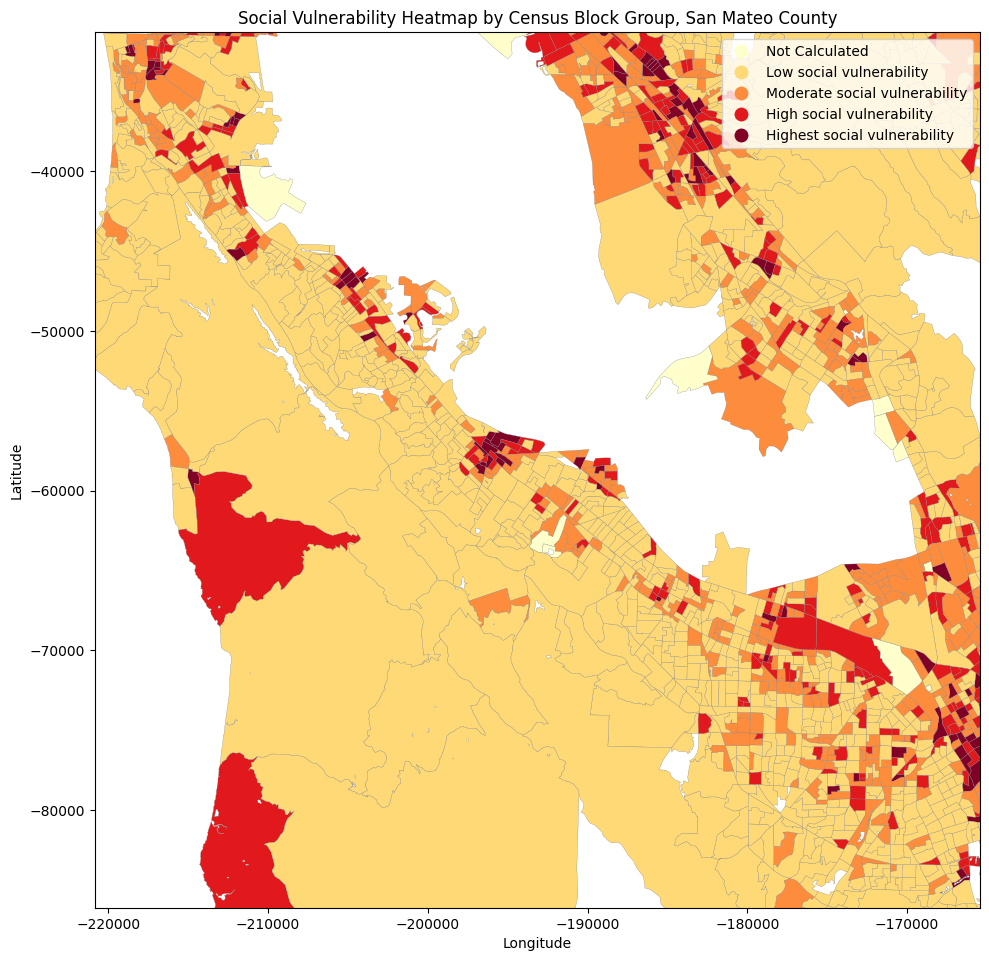

In [395]:
#make a cloropleth to look at social vulnerability
desired_order = ['Not Calculated','Low social vulnerability', 'Moderate social vulnerability',  'High social vulnerability', 'Highest social vulnerability']
vuln['socVulnRank'] = vuln['socVulnRank'].astype('category').cat.reorder_categories(desired_order, ordered=True)

bbox = (-220842.9475,-165437.4953,-86102.5863,-31302.1097)

fig, ax = plt.subplots(figsize=(10, 12))

vuln.plot(column='socVulnRank', cmap='YlOrRd', legend=True, ax=ax, edgecolor='gray', linewidth=0.2)

ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])

plt.title('Social Vulnerability Heatmap by Census Block Group, San Mateo County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

## Next Steps....

1. Perform a spatial join the community vulnerability with final parcel data
2. Calculate resiliency tax surcharge rates per parcel to examine cost distribution for financing flood protection based on ABAG infrastructure cost estimates and special asessment engineering logic (this is a separate workbook for my thesis)
3. Examine indicators of cost burden x social vulnerability for distributional impact